In [22]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler


In [23]:
path = (r'N:\Personal_Projects\random_forest\mobile_ads_project\mobile_ads.csv')
df = pd.read_csv(path)

In [24]:
df

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


In [25]:
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [26]:
df.tail()

,User ID,Gender,Age,EstimatedSalary,Purchased
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0
399,15594041,Female,49,36000,1


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


In [28]:
df.describe()

,User ID,Age,EstimatedSalary,Purchased
count,4.000000e+02,400.000000,400.000000,400.000000
mean,1.569154e+07,37.655000,69742.500000,0.357500
std,7.165832e+04,10.482877,34096.960282,0.479864
min,1.556669e+07,18.000000,15000.000000,0.000000
25%,1.562676e+07,29.750000,43000.000000,0.000000
50%,1.569434e+07,37.000000,70000.000000,0.000000
75%,1.575036e+07,46.000000,88000.000000,1.000000
max,1.581524e+07,60.000000,150000.000000,1.000000


In [29]:
df.shape

(400, 5)

In [30]:
df.isna().sum()

User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

In [31]:
df=df.drop_duplicates() # drop any duplicates values

In [32]:
df.Purchased.value_counts() # boolean metrics only

Purchased
0    257
1    143
Name: count, dtype: int64

In [33]:
df.nunique() # cardinality test

User ID            400
Gender               2
Age                 43
EstimatedSalary    117
Purchased            2
dtype: int64

Text(0.5, 1.0, 'Target distribution')

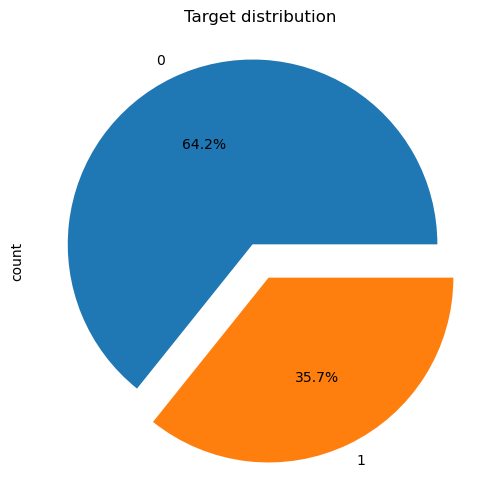

In [34]:
plt.figure(figsize=(6,6))
df['Purchased']. value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%').set_title("Target distribution")

target is inbalanced accross the population

we can consider to under sample the majority or over sample the minority :

the Synthetic Minority Over-sampling Technique (SMOTE) to generate synthetic samples for the minority class.

c:\Users\nihar\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


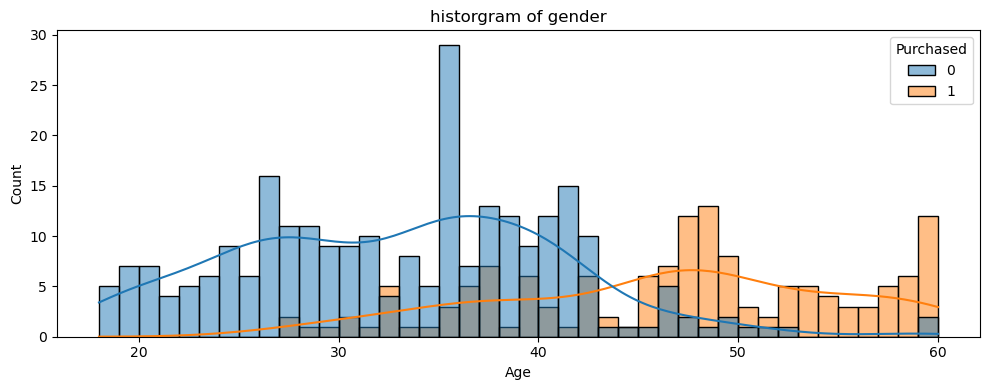

In [35]:
plt.figure(figsize=(10,4))
sns.histplot(data= df, x='Age', hue='Purchased',binwidth =1, kde=1)
plt.title("historgram of gender")
plt.tight_layout()
plt.show()


age below 30 were less likely to purchase than not

age more than 45-60 were more likely to purchase or not insight :

can create a feature for age ranges adult , adolescent or teen but not that necessary

AttributeError: 'numpy.int64' object has no attribute 'startswith'

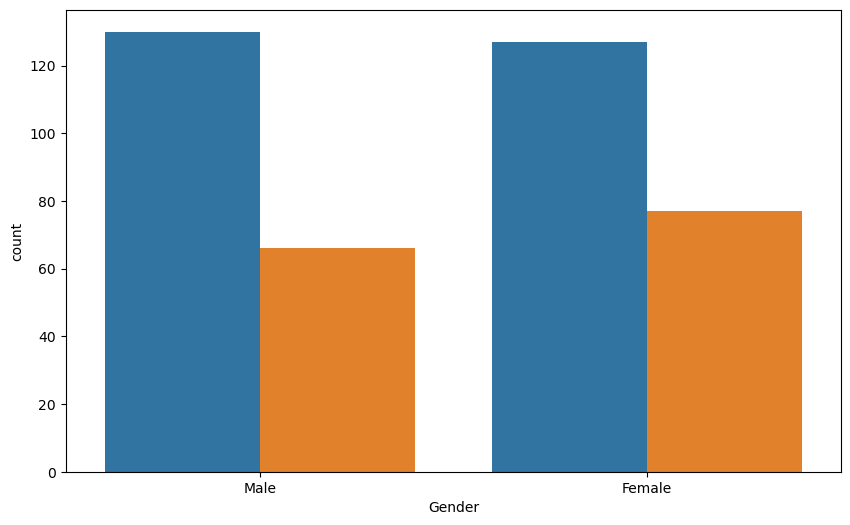

In [36]:
# gender propotion in purchasing 
plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', hue='Purchased', data=df)
plt.title('Count of Purchasers by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

as seen from the histogram the propotion is very much equally distributed in both of the genders

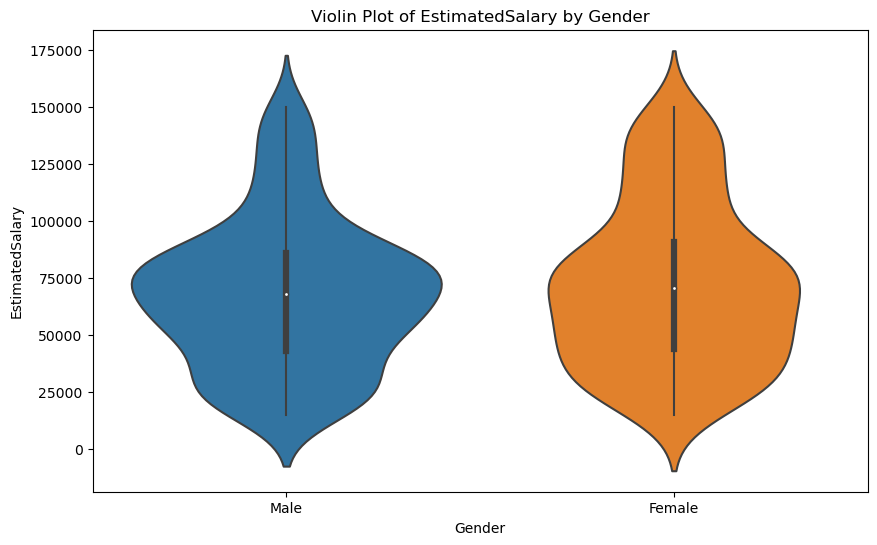

In [59]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Gender',y = 'EstimatedSalary', data=df)
plt.title('Violin Plot of EstimatedSalary by Gender')
plt.xlabel('Gender')
plt.ylabel('EstimatedSalary')
plt.show()

#   Salary is also equally distributed through out not needed to check further

In [37]:
le = LabelEncoder()
df['GenderEncode'] = le.fit_transform(df.Gender)

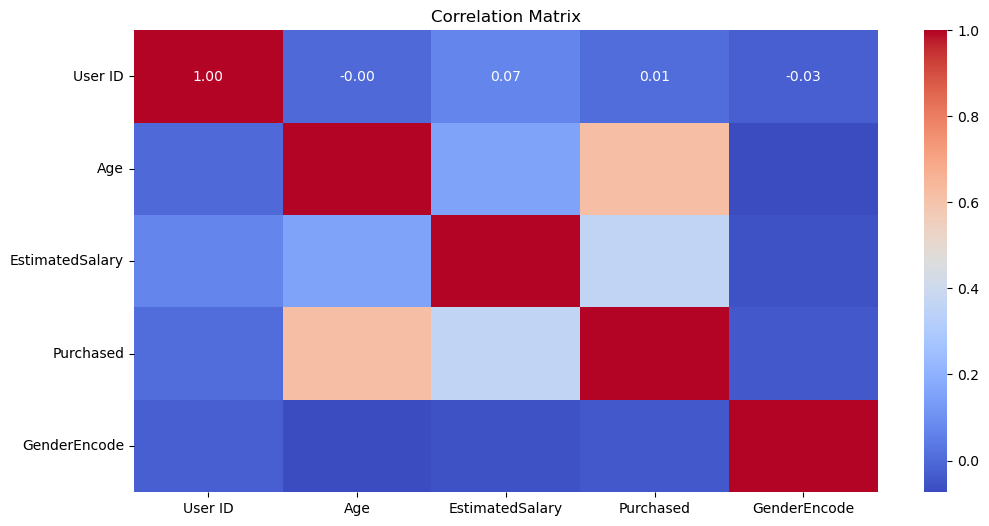

In [38]:
# Assuming 'Gender' is a categorical variable encoded as integers
# If 'Gender' is not numerical, use appropriate correlation metrics for categorical data

# Drop the 'Gender' column for the correlation matrix
copydf = df.drop(['Gender'], axis=1)

#Form the correlation matrix
corrmat = copydf.corr()

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(data=corrmat, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


two metrics as we can see gives us a good realation to the purchase i.e age and estimated salary lets use those and implement the model

In [54]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def nueralnet(X_train,X_test,y_train,y_test):
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(3,)),  # Input layer with 10 features
            tf.keras.layers.Dense(64, activation='relu'),  # Dense hidden layer with ReLU activation
            tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)
        loss, accuracy = model.evaluate(X_test, y_test)
        print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

In [56]:
from sklearn.metrics import accuracy_score
def lossfn(ytrue , pred):
        accuracy = accuracy_score(ytrue, pred)
        return accuracy


In [58]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

def randomforest(X_train,X_test,y_train,y_test):
    rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)

    # Train the model on the training data
    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Test Accuracy: {accuracy:.4f}')

def xgb(X_train,X_test,y_train,y_test):
    param_grid = {
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [150, 180, 220],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }

    # Instantiate the XGBClassifier
    xgb_classifier = XGBClassifier(random_state=42)

    # Create GridSearchCV
    grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Print the best hyperparameters
    print("Best Hyperparameters:", grid_search.best_params_)

    # Make predictions on the test data using the best model
    y_pred = grid_search.best_estimator_.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Test Accuracy: {accuracy:.4f}')

In [51]:
df

,User ID,Gender,Age,EstimatedSalary,Purchased,GenderEncode
0,15624510,Male,19,19000,0,1
1,15810944,Male,35,20000,0,1
2,15668575,Female,26,43000,0,0
3,15603246,Female,27,57000,0,0
4,15804002,Male,19,76000,0,1
...,...,...,...,...,...,...
395,15691863,Female,46,41000,1,0
396,15706071,Male,51,23000,1,1
397,15654296,Female,50,20000,1,0
398,15755018,Male,36,33000,0,1


In [59]:
x = df.drop(['Purchased','Gender','User ID'],axis=1)
y = df['Purchased']

xtrain , xtest , ytrain,ytest = train_test_split(x,y,test_size=0.2,random_state=3)
print("nueral net ")
nueralnet(xtrain,xtest,ytrain,ytest)
print("randomforest ")
randomforest(xtrain,xtest,ytrain,ytest)
print("XGBClassifier")
xgb(xtrain,xtest,ytrain,ytest)

nueral net 
Epoch 1/10
9/9 [==============================] - 1s 25ms/step - loss: 0.7479 - accuracy: 0.3125 - val_loss: 0.7279 - val_accuracy: 0.3750
Epoch 2/10
9/9 [==============================] - 0s 5ms/step - loss: 0.7031 - accuracy: 0.4965 - val_loss: 0.6860 - val_accuracy: 0.5938
Epoch 3/10
9/9 [==============================] - 0s 5ms/step - loss: 0.6633 - accuracy: 0.6319 - val_loss: 0.6485 - val_accuracy: 0.7500
Epoch 4/10
9/9 [==============================] - 0s 5ms/step - loss: 0.6270 - accuracy: 0.7743 - val_loss: 0.6159 - val_accuracy: 0.8438
Epoch 5/10
9/9 [==============================] - 0s 5ms/step - loss: 0.5952 - accuracy: 0.7986 - val_loss: 0.5870 - val_accuracy: 0.8438
Epoch 6/10
9/9 [==============================] - 0s 4ms/step - loss: 0.5666 - accuracy: 0.8333 - val_loss: 0.5606 - val_accuracy: 0.8438
Epoch 7/10
9/9 [==============================] - 0s 5ms/step - loss: 0.5412 - accuracy: 0.8333 - val_loss: 0.5372 - val_accuracy: 0.8438
Epoch 8/10
9/9 [=====